In [17]:
from devgpt_processing.load.model import Issue, Conversation
# sqlalchemy
from sqlalchemy import create_engine
from sqlalchemy.orm import sessionmaker
from sqlalchemy.ext.declarative import declarative_base
# pandas
import pandas as pd

In [18]:
# session
engine = create_engine('sqlite:///devgpt.sqlite')
Session = sessionmaker(bind=engine)
session = Session()


In [19]:

# Get all title and body text from the issues table
issues = session.query(Issue).all()
issues_data = {'id': [issue.id for issue in issues], 'title': [issue.title for issue in issues], 'body': [issue.body for issue in issues]}
issues_df = pd.DataFrame(issues_data)

# Get all conversations
conversations = session.query(Conversation).all()
conversations_data = {'Prompt': [conversation.Prompt for conversation in conversations], 'Answer': [conversation.Answer for conversation in conversations], 'id': [conversation.id for conversation in conversations]}
conversations_df = pd.DataFrame(conversations_data)


In [20]:
issues_df.head()

,id,title,body
0,6106233011375999205,Support stream multiplexing for websockets,### Specification\r\n\r\nTo avoid the overhead...
1,-7238836597722247918,[Bug] Assignee field in jira-search contains a...,"**Describe the bug**\r\n""Assignee"" column in j..."
2,-5567168028862829697,blog article: super mario effect and mastery l...,turn this into a blog https://chat.openai.com/...
3,8424398699835162855,User should see indication that they have tapped,Right now there are no tapped states on iOS or...
4,4163140116668954309,What time does spacer use?,"I'm unsure if this is a bug or a feature, but ..."


In [21]:
# dask client
from dask.distributed import Client
import os
# use a different port for dashboard
port = 5000
os.environ['DASK_SCHEDULER_PORT'] = str(port)
client = Client(n_workers=4, threads_per_worker=2, dashboard_address=f':{port}')
# use gpu on mac
client.run(lambda: os.environ.__setitem__('CUDA_VISIBLE_DEVICES', '0'))
# print dashboard link
client



/Users/anushkrishnav/.local/share/virtualenvs/DevGPT-pxPYave5/lib/python3.11/site-packages/distributed/node.py:182: UserWarning: Port 5000 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 63578 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:63578/status,
Dashboard: http://127.0.0.1:63578/status,Workers: 4
Total threads: 8,Total memory: 16.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:63579,Workers: 4
Dashboard: http://127.0.0.1:63578/status,Total threads: 8
Started: Just now,Total memory: 16.00 GiB
Comm: tcp://127.0.0.1:63593,Total threads: 2
Dashboard: http://127.0.0.1:63597/status,Memory: 4.00 GiB
Nanny: tcp://127.0.0.1:63582,


Langugage detection

In [22]:
import dask.dataframe as dd
import sqlite3
import nltk
import ssl
ssl._create_default_https_context = ssl._create_unverified_context
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string
import fasttext

# import dask client


# Download NLTK stopwords and punctuation data
nltk.download('stopwords')
nltk.download('punkt')

# Function for text cleaning using NLTK
def clean_text(text):
    # Tokenize the text
    tokens = word_tokenize(text)

    # Remove punctuation and convert to lowercase
    tokens = [word.lower() for word in tokens if word.isalnum()]

    # remove newline characters
    tokens = [word.replace('\\n', '') for word in tokens]

    # conveert to lower case
    tokens = [word.lower() for word in tokens]

    return ' '.join(tokens)

import dask.dataframe as dd
import pandas as pd

# Reset the index of your Pandas DataFrame
issues_df = issues_df.reset_index(drop=True)
conversations_df = conversations_df.reset_index(drop=True)

# Convert the Pandas DataFrame to a Dask DataFrame
issues_ddf = dd.from_pandas(issues_df, npartitions=4, sort=False)
conversations_ddf = dd.from_pandas(conversations_df, npartitions=4, sort=False)


# Clean the text of the title and body columns
issues_ddf['title'] = issues_ddf['title'].apply(clean_text)
issues_ddf['body'] = issues_ddf['body'].apply(clean_text)
conversations_ddf['Prompt'] = conversations_ddf['Prompt'].apply(clean_text)
conversations_ddf['Answer'] = conversations_ddf['Answer'].apply(clean_text)



# Define a function to predict the language using FastText
def predict_language(text):
    language_classifier = fasttext.load_model('lid.176.bin')
    predictions = language_classifier.predict(text)
    language = predictions[0][0].replace('__label__', '')
    return language
    

# Use Dask's 'apply' method to predict the language and add it as a new column
issues_ddf['language'] = issues_ddf['body'].apply(predict_language, meta=('language', str))
conversations_ddf['language'] = conversations_ddf['Prompt'].apply(predict_language, meta=('language', str))


# Compute the result (this step is necessary to execute the Dask computation)
issues_ddf = issues_ddf.compute()
conversations_ddf = conversations_ddf.compute()

# quite the cell output
from IPython.display import clear_output
clear_output()


In [23]:
# get a random englisxh prompt
prompt = conversations_ddf[conversations_ddf['language'] == 'en']['Prompt'].sample().values[0]

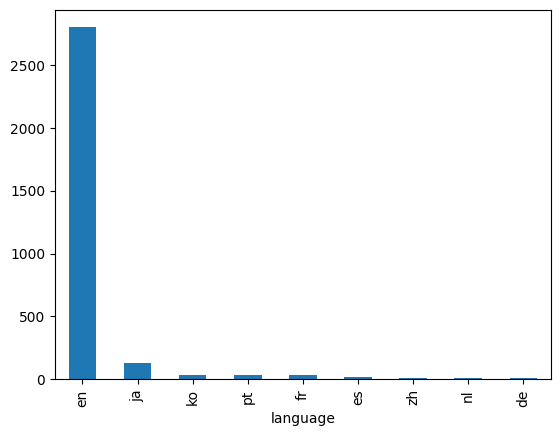

In [24]:
issues_ddf.head()
# unique languages
issues_ddf['language'].unique()
# distribution of languages
issues_ddf['language'].value_counts()
import matplotlib.pyplot as plt

# Create a bar plot of the language distribution
issues_ddf['language'].value_counts().plot(kind='bar')
plt.show()


In [25]:
# update rows with language  in database
for index, row in issues_ddf.iterrows():
    session.query(Issue).filter(Issue.id == row['id']).update({Issue.language: row['language']})
session.commit()

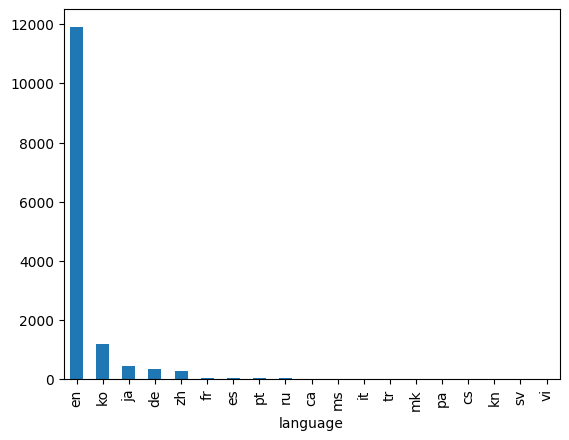

In [26]:
conversations_ddf.head()
# unique languages
conversations_ddf['language'].unique()
# distribution of languages
conversations_ddf['language'].value_counts()
import matplotlib.pyplot as plt

# Create a bar plot of the language distribution
conversations_ddf['language'].value_counts().plot(kind='bar')
plt.show()

In [27]:
# update conversations with language in database
for index, row in conversations_ddf.iterrows():
    session.query(Conversation).filter(Conversation.id == row['id']).update({Conversation.language: row['language']})
session.commit()

# close session
session.close()

2023-10-30 11:49:09,214 - tornado.application - ERROR - Exception in callback <bound method SystemMonitor.update of <SystemMonitor: cpu: 11 memory: 90 MB fds: 267>>
Traceback (most recent call last):
  File "/Users/anushkrishnav/.local/share/virtualenvs/DevGPT-pxPYave5/lib/python3.11/site-packages/tornado/ioloop.py", line 919, in _run
    val = self.callback()
          ^^^^^^^^^^^^^^^
  File "/Users/anushkrishnav/.local/share/virtualenvs/DevGPT-pxPYave5/lib/python3.11/site-packages/distributed/system_monitor.py", line 168, in update
    net_ioc = psutil.net_io_counters()
              ^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/anushkrishnav/.local/share/virtualenvs/DevGPT-pxPYave5/lib/python3.11/site-packages/psutil/__init__.py", line 2119, in net_io_counters
    rawdict = _psplatform.net_io_counters()
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
OSError: [Errno 12] Cannot allocate memory
